In [23]:
# Where are you plotting: from home: 1; from IMDEA = 0
HOME = 0

### basic stuff
import os
import os.path
from os import path
import numpy as np
### for sorting array of arrays based on 1st or 2nd... element
import operator
from operator import itemgetter

# Import math Library
import math

### matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

### for curve fitting
from scipy.optimize import curve_fit
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import find_peaks

### for vtk import
import vtk
from vtk.util.numpy_support import vtk_to_numpy

### for files
from pathlib import Path
from PyPDF2 import PdfMerger
from PyPDF2 import PdfFileMerger
from PyPDF2 import PdfFileReader

### for globbing (using * for search some pattern)
import glob

In [2]:
pgf_with_latex = {                      # setup matplotlib to use latex for output
    'pgf.texsystem': 'pdflatex',        # change this if using xetex or lautex
    'text.usetex': True,                # use LaTeX to write all text
    'font.size' : 10,
    #'font.family': 'sans-serif',
    'font.family': 'serif',
    #'font.serif': ['Computer Modern Roman'],  # blank entries should cause plots
    'font.serif': [],                          # blank entries should cause plots 
    'font.sans-serif': [],                     # to inherit fonts from the document
    'font.monospace': [],
    'text.latex.preamble':r'\usepackage[utf8]{inputenc}\usepackage[T1]{fontenc}\usepackage[detect-all]{siunitx}\usepackage{amsmath}\usepackage{bm}\usepackage{color}'
    #'text.latex.preamble':r'\usepackage{sansmath}\sansmath\usepackage[utf8]{inputenc}\usepackage[T1]{fontenc}\usepackage[detect-all]{siunitx}\usepackage{amsmath}\usepackage{bm}'
    }

mpl.rcParams.update(pgf_with_latex)

plt.rcParams["axes.axisbelow"] = False ### draw axes, ticks and labels always above everything elese

In [3]:
what_axis = {
    0: r'$\text{Iteration}$',
    1: r'$\text{Time}\quad t\cdot V_S / R_S$',
    2: r'$\text{Time}\quad t / s$',
    3: r'$\text{Needle}\quad$',
    4: r'$\text{Undelcooling}\quad \Delta $' ,
    5: r'$\text{Undercooling}\quad \Delta S$',
    6: r'$\text{Supersaturation}\quad \Omega$',
    7: r'$\text{Supersaturation}\quad \Omega$',
    8: r'$\text{Length}\quad$',
    9: r'$\text{Length}\quad$',
    10: r'$\text{Velocity}\quad V / V_s$',
    11: r'$\text{Velocity}\quad V$',
    12: r'$\text{Radius}\quad R / R_s$',
    13: r'$\text{Radius}\quad$',
    14: r'$\text{Péclet}\quad Pe$',
    15: r'$\text{Péclet Iv.}\quad $',
    16: r'$\text{X_tip}\quad V / V_s$',
    17: r'$\text{Y_tip}$',
    18: r'$\text{r_x}\quad$',
    19: r'$\text{r_y}\quad$',
    20: r'$\text{r}\quad$',
    21: r'$\text{Theta}\quad \theta / rad$',
    22: r'$\text{dl[0]}\quad$',
    23: r'$\text{dl[1]}\quad$',
    24: r'$\text{X-offset}\quad$',
    25: r'$\text{X-offset}\quad$',
    26: r'$\text{Num. Needles}\quad$',
    27: r'$\text{Needles\' size}\quad$',
    28: r'$\text{Computation}\quad t/ s$',
    29: r'$\text{max. fluid vel. comp.}\quad$',
    30: r'$\text{Order}\quad$',
    31: r'$\text{X_tip_max}\quad$',
    32: r'$\text{Y_tip_max}\quad$',
    33: r'$\text{X_tip_PB}\quad$',
    34: r'$\text{Y_tip_PB}\quad$',
    35: r'$\text{Dir. X}\quad V / V_s$',
    36: r'$\text{Dir. Y}\quad V / V_s$',
    37: r'$\text{Undercooling ind.}\quad$',
    38: r'$\text{Oversaturation ind.}\quad$'
}

In [4]:
##################################################
### column numbers in the needle output files ####
##################################################

LENGTH_RS = 8
LENGTH_SI = 9
VELOCITY_VS = 10
VELOCITY_SI = 11
RADIUS_RS = 12
RADIUS = 13
DELTA = 4
DELTA_IND = 37
OMEGA_IND = 38
OMEGA = 6
PECLET = 14
Y_OFFSET = 25
ACTIVE_NEEDLES = 26
SIZE_NEEDLES = 27
COMPT_TIME = 28
VEL_MAX = 29
ORDER = 30

X_TIP = 16
Y_TIP = 17
RX = 18
RY = 19

X_TIP_MAX = 31
Y_TIP_MAX = 32
X_TIP_PB = 33
Y_TIP_PB = 34

# time_idx = time_s  # WHAT IS THAT?
TIME_RSVS = 1
TIME_S = 2

In [5]:
# FUNCTION FOR REACHING THE LAST LINE IN THE FILE (AND OTHER MINOR CHANGES)
def last_line_from_file(path_to_file):
    with open(path_to_file, "r") as f:
        last_line = f.readlines()[-1]
        last_line = list(last_line.split(" \t"))   # converting from string to list
        last_line = last_line[:-1]                 # removing the last element (/n) of the list
    return last_line

In [6]:
# is the same as the SAMPLE RATE and could be also computed as: total_time/data_points (e.g: 90s/10000 = 0.009)
def getting_time_step(time):
    # time should be a list with all the time values...
    steps = []
    for t in range(len(time)):
        if t == len(time)-1:
            break
        step = time[t+1] - time[t]
        steps.append(float(step))
    step = np.mean(steps)
    return step

In [7]:
def get_data_from_simulation(survival_needles, needle_list, folder_wd, desired_needle, dimensionless):
    if dimensionless == 1:
        TIME = TIME_RSVS
        VELOCITY = VELOCITY_VS
        LENGTH = LENGTH_RS
    else:
        TIME = TIME_S
        VELOCITY = VELOCITY_SI
        LENGTH = LENGTH_SI

    ###########################################################
    needle_file_path = folder_wd + '/' + needle_list[survival_needles[desired_needle]]
    test_data = np.loadtxt(needle_file_path, skiprows = 1)
    
    velocity = test_data[:, VELOCITY]
    time = test_data[:, TIME]
    length = test_data[:, LENGTH]
    step = getting_time_step(time)
    n = len(time)
    total_time = step * n
    
    return velocity, time, length, step, total_time

In [8]:
def get_needles_number(name):
    pos = name.find("N")
    stripped_name = name[pos:]
    pos = stripped_name.find("_")
    name = stripped_name[1:pos]
    return int(name)

In [9]:
def spiky_function(t, amp, v0, sp, f, t0):
    return v0 - 0.5*amp*((1.-sp)*np.cos(2*math.pi*(t-t0)*f)+2*sp*abs(np.cos(math.pi*(t-t0)*f)) - sp)

In [10]:
FITTING = False

In [11]:
def decaying_function(t, amp, v0, sigma, f, t0):
    return amp * np.exp(-sigma * t) * np.cos(2*math.pi*f *(t - t0)) + v0

## Plot fitted for a Grid of Needles

In [12]:
def plot_big_grid_fitted(desired_start, survival_needles, needle_list, plot_name, folder_wd, dimensionless,):
    if dimensionless == 1:
        TIME = TIME_RSVS
        VELOCITY = VELOCITY_VS
        LENGTH = LENGTH_RS
    else:
        TIME = TIME_S
        VELOCITY = VELOCITY_SI
        LENGTH = LENGTH_SI
    ###########################################################
    # Color setting
    ###########################################################
    ### colors
    color_smooth = 'k'

    ### markers
    marker_smooth = '-'
    ###########################################################
    # Setting Grid dimensions
    ###########################################################
    Tot = len(survival_needles) # Number of subplots desired
    Cols = int(Tot ** 0.5)
    Rows = Tot // Cols
    Rows += Tot % Cols
    #Position = range(1, Tot + 1)
    ###########################################################
    # Preparing indexes in wich iterate & removing indexes of empty plots
    ###########################################################
    Row_list = list(range(Rows))
    Col_list = list(range(Cols))
    subplots = []
    for i in Row_list:
        for j in Col_list:
            subplots.append((i,j))
    while Tot < len(subplots):
        subplots.pop()
    ###########################################################
    # Getting data of all the needles before plotting the current needle velocity
    ###########################################################
    needles_vel_max = []
    k = 0
    for i, j in subplots:
        needle_file_path = folder_wd + '/' + needle_list[survival_needles[k]]
        test_data = np.loadtxt(needle_file_path, skiprows = 1)
        velocities = list(test_data[:,VELOCITY])
        vel_max = np.max(velocities)
        needles_vel_max.append(vel_max)
        
    needles_max_mean = np.mean(needles_vel_max)
    ###########################################################
    fig1 = plt.figure(figsize = (float(Cols*6),float(Rows*3)))
    fig1.suptitle(plot_name)
    gs = gridspec.GridSpec(nrows = Rows, ncols = Cols, wspace = .55, hspace = .5)
    ###########################################################
    fig2 = plt.figure(figsize = (float(Cols*6),float(Rows*3)))
    fig2.suptitle(plot_name)
    ###########################################################
    k = 0
    data = []
    for i, j in subplots:
        needle_file_path = folder_wd + '/' + needle_list[survival_needles[k]]
        test_data = np.loadtxt(needle_file_path, skiprows = 1)
        velocity, time, length, step, total_time = get_data_from_simulation(survival_needles, needle_list, folder_wd, 
                                                     k, dimensionless)
        freq, PSD, L, freq_max, PSD_max_pos = the_FFT(step, total_time, velocity, time)
        ##################################################################
        ### calculate the value of pulling velocity from the plot name ###
        ##################################################################
        vp = float(plot_name[1:2])
        if vp == 1:
            vp = vp*1.e-4
        else:
            vp = vp*1.e-5
        ##################################################################
        ### calculate velocity as derivative of the length (smoother) ####
        ##################################################################
        n = 50 #smoothness
        data_time_collapsed = test_data[::n, TIME]
        data_length_collapsed = test_data[::n, LENGTH]
        data_dLdt = np.gradient(data_length_collapsed, data_time_collapsed)
        ##################################################################
        ##################################################################
        ### the real fitting                                          ####
        ##################################################################
        start, finish, r_squared, xfit_data, yfit_data, popt, pcov = calling_fitting(desired_start, total_time, 
                                                                                     data_time_collapsed, 
                                                                                     data_dLdt, freq_max, vp, k)
                
        data.append([k, r_squared, start, finish, popt])
        
        
        # PLOTTING ##################################################################
        want_ax1 = True
        if want_ax1 == True:
            ###########################################################
            ax1 = fig1.add_subplot(gs[i, j])
            ax1.tick_params(direction = 'in', which = 'both', bottom = True, top = True, left = True, right = True)
            ax1.minorticks_on()
            ax1.set_title(r'$\text{Needle}$ %d' %survival_needles[k])
            ###################### 
            
            ax1.plot(test_data[:, TIME], test_data[:, VELOCITY], color = '0.8')
            ax1.plot(data_time_collapsed, data_dLdt, marker_smooth, color=color_smooth)
            if FITTING == True:
                ax1.plot(xfit_data, spiky_function(xfit_data, *popt), color = 'r', 
                        label = 'A=%5.5f m/s, $V_0$=%5.5f $\si{\micro\meter}/s$, $S$=%5.3f, $f$=%5.3f Hz, t0=%5.3f s,' 
                        %tuple(popt) + '\n Data: smoothness = %d, start = %d s, finish = %d s, $\quad$  $\\bm{R^2= %5.3f}$' 
                        %tuple([n, start, finish, r_squared]))
            else:
                ax1.plot(xfit_data, decaying_function(xfit_data, *popt), color = 'r', 
                        label = 'A=%5.5f m/s, $V_0$=%5.5f $\si{\micro\meter}/s$, $\sigma$=%5.3f, $f$=%5.3f Hz, t0=%5.3f s,' 
                        %tuple(popt) + '\n Data: smoothness = %d, start = %d s, finish = %d s, $\quad$  $\\bm{R^2= %5.3f}$' 
                        %tuple([n, start, finish, r_squared]))
            ######################

            ax1.set_xlabel(what_axis[TIME])
            ax1.set_ylabel(what_axis[VELOCITY])

            velocity = list(test_data[:,VELOCITY])
            vel_max = np.max(velocity)
            vel_mean = np.mean(velocity)

            if (vel_max / vel_mean) > 7:
                if (5 * vel_mean) > needles_max_mean:
                    ax1.set_ybound(lower = 0, upper = (needles_max_mean + vel_mean))
                else:
                    ax1.set_ybound(lower = 0, upper = 5*vel_mean)
            else:
                ax1.set_ybound(lower = 0, upper = None)
            ax1.set_xbound(lower = 0, upper = None)
            ax1.legend(ncol = 1, prop={'size': 4}, borderpad = 1, borderaxespad = 0.65)
            
        want_ax2 = True
        if want_ax2 == True:
            ###########################################################
            ax2 = fig2.add_subplot(gs[i, j])
            ax2.tick_params(direction = 'in', which = 'both', bottom = True, top = True, left = True, right = True)
            ax2.minorticks_on()
            ax2.set_title(r'$\text{FFT for Needle}$ %d' %survival_needles[k])
            ###################### 
            ax2.plot(np.real(freq[L]), np. real(PSD[L]), 'b')
            ax2.plot(np.real(freq[PSD_max_pos]), np.real(PSD[PSD_max_pos]), "x", color ='r')
            plt.xlabel('Freq (Hz)')
            plt.ylabel('FFT Amplitude |X(freq)|')
            ax2.set_xbound(lower = 0.0, upper = 1)
            ax2.set_ybound(lower = None, upper = None)
            ###########################################################
            plt.subplots_adjust(left = .09, right = .975, top = .95, bottom = .1)
        k = k + 1
    if want_ax1 == True:
        if FITTING == True:
            fig1.savefig('./fitting_spiky_' + plot_name + '.pdf', transparent = True, dpi = 600)
        else:
            fig1.savefig('./fitting_decaying_' + plot_name + '.pdf', transparent = True, dpi = 600)
    if want_ax2 == True:
        fig2.savefig('./fft_' + plot_name + '.pdf', transparent = True, dpi = 600)
    return data

## Fitting process works thanks to this function called: calling_fitting. 

In [13]:
def calling_fitting(desired_start, total_time, data_time_collapsed, data_dLdt, freq_max, vp, k):
    ##################################################################
    ### fitting desired curve to our data                         ####
    ##################################################################
    if FITTING == True:
        ## forward
        counter = 0
        fordward_start_list = []
        fordward_r_squared_list = []
        fordward_data = []
        finish = int(total_time-1)
        for starting in range(desired_start, finish):          
            if (finish - starting) > 22:
                try:
                    r_squared, xfit_data, yfit_data, popt, pcov = fitting(starting, finish, data_time_collapsed, 
                                                                          data_dLdt, freq_max, vp)
                except:
                    print('unable to fit fordward')
                    fordward_best_r_squared = 0
                fordward_data.append([starting, finish, r_squared, xfit_data, yfit_data, popt, pcov])
                fordward_start_list.append(starting)
                fordward_r_squared_list.append(r_squared)
            counter += 1

        size = len(fordward_r_squared_list)
        while (size > 1):
            fordward_best_r_squared = np.max(fordward_r_squared_list)
            f_pos = np.where(fordward_r_squared_list == fordward_best_r_squared)[0][0]
            start_i = fordward_data[f_pos][0]
            finish_i = fordward_data[f_pos][1]
            popt_i = fordward_data[f_pos][5]
            f = popt_i[3]
            if ((finish_i - start_i) > 5.25*(1/f)):
                break
            else:
                fordward_data.pop(f_pos)
                fordward_start_list.pop(f_pos)
                fordward_r_squared_list.pop(f_pos)
                f_pos = f_pos - 1
                size = size - 1

        ## backwards
        counter = 0
        backward_finish_list = []
        backward_r_squared_list = []
        backward_data = []
        start = desired_start
        for finishing in range(int(total_time-1), desired_start, -1):
            if (finishing - start) > 22:
                try:
                    r_squared, xfit_data, yfit_data, popt, pcov = fitting(start, finishing, data_time_collapsed, 
                                                                          data_dLdt, freq_max, vp)
                except:
                    print('unable to fit backward')
                    backward_best_r_squared = 0
                backward_data.append([start, finishing, r_squared, xfit_data, yfit_data, popt, pcov])
                backward_finish_list.append(finishing)
                backward_r_squared_list.append(r_squared)
            counter += 1

        size = len(backward_data)
        while (size > 1):
            backward_best_r_squared = np.max(backward_r_squared_list)
            b_pos = np.where(backward_r_squared_list == backward_best_r_squared)[0][0]
            start_i = backward_data[b_pos][0]
            finish_i = backward_data[b_pos][1]
            popt_i = backward_data[b_pos][5]
            f = popt_i[3]
            if (finish_i - start_i) > 5.25*(1/f):
                break
            else:
                backward_data.pop(b_pos)
                backward_finish_list.pop(b_pos)
                backward_r_squared_list.pop(b_pos)
                b_pos = b_pos - 1
                size = size - 1
        ## selecting the best
        if fordward_best_r_squared > backward_best_r_squared:
            start = fordward_data[f_pos][0]
            finish = fordward_data[f_pos][1]
            print('from', start,' to ', finish)
            r_squared = fordward_best_r_squared
            print(fordward_best_r_squared)
            xfit_data = fordward_data[f_pos][3]
            yfit_data = fordward_data[f_pos][4]
            popt = fordward_data[f_pos][5]
            f = popt[3]
            pcov = fordward_data[f_pos][6]
            #print('5*(1/f)', 5*(1/f))
            #print('finish - start', finish - start)
            print('-------------------------------')
        else:
            start = backward_data[b_pos][0]
            finish = backward_data[b_pos][1]
            print('from', start,'to', finish)
            r_squared = backward_best_r_squared
            print(backward_best_r_squared)
            xfit_data = backward_data[b_pos][3]
            yfit_data = backward_data[b_pos][4]
            popt = backward_data[b_pos][5]
            f = popt[3]
            pcov = backward_data[b_pos][6]
            #print('5*(1/f)', 5*(1/f))
            #print('finish - start', finish - start)
            print('-------------------------------')
    else:
        ## only backwards
        counter = 0
        backward_finish_list = []
        backward_r_squared_list = []
        backward_data = []
        start = desired_start
        for finish in range(int(total_time), start, -1):
            if (finish - start) > 50:
                try:
                    r_squared, xfit_data, yfit_data, popt, pcov = fitting(start, finish, data_time_collapsed, 
                                                                          data_dLdt, freq_max, vp)
                    backward_data.append([start, finish, r_squared, xfit_data, yfit_data, popt, pcov])
                    backward_finish_list.append(finish)
                    backward_r_squared_list.append(r_squared)
                except:
                    print('unable to fit backward')
            counter += 1

        size = len(backward_data)
        while (size > 1):
            backward_best_r_squared = np.max(backward_r_squared_list)
            b_pos = np.where(backward_r_squared_list == backward_best_r_squared)[0][0]
            start_i = backward_data[b_pos][0]
            finish_i = backward_data[b_pos][1]
            popt_i = backward_data[b_pos][5]
            f = popt_i[3]
            if (finish_i - start_i) > 5.25*(1/f):
                break
            else:
                backward_data.pop(b_pos)
                backward_finish_list.pop(b_pos)
                backward_r_squared_list.pop(b_pos)
                b_pos = b_pos - 1
                size = size - 1
                
        start = backward_data[b_pos][0]
        finish = backward_data[b_pos][1]
        print('from', start,'to', finish)
        r_squared = backward_best_r_squared
        print(backward_best_r_squared)
        xfit_data = backward_data[b_pos][3]
        yfit_data = backward_data[b_pos][4]
        popt = backward_data[b_pos][5]
        f = popt[3]
        pcov = backward_data[b_pos][6]
        #print('5*(1/f)', 5*(1/f))
        #print('finish - start', finish - start)
        print('-------------------------------')
    
    return start, finish, r_squared, xfit_data, yfit_data, popt, pcov

## The heart for the fitting is here:

In [14]:
def fitting(time_to_start, time_to_finish, data_time_collapsed, data_dLdt, freq_max, vp):
    ##################################################################
    ### fitting desired curve to our data                         ####
    ##################################################################
    start = np.where(data_time_collapsed > time_to_start)[0][0]
    #print('start', start)
    #print(data_time_collapsed)
    finish = np.where(data_time_collapsed > (time_to_finish-1))[0][0]
    #print('finish', finish)
    xfit_data = data_time_collapsed[start:finish]
    yfit_data = data_dLdt[start:finish]
   
    #decaying_function(amp, v0, sigma, f, t0):
    popt, pcov = curve_fit(decaying_function,  # our function
                            xfit_data,             # measured x values
                            yfit_data              # measured y values
                            #,bounds = ([0.0, 0.0, 0.0, 0.0, -100.0], [10*vp, 2*vp, 1.0, 1.0, 100.0]) 
                            ,p0=(0.005, vp, 0.1, freq_max, 0.0)  # the initial guess for the four parameters
                            )
    residuals = yfit_data - decaying_function(xfit_data, *popt)
    #### R² value ###
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((yfit_data - np.mean(yfit_data))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared, xfit_data, yfit_data, popt, pcov

## We perform the FFT of the data for having a guess value for the fitting

In [15]:
def the_FFT(dt, total_time, velocity, time):
    ##############################
    ### computing the FFT     ####
    ##############################
    n = len(time)
    t = np.arange(0, total_time, dt)
    freq = (1/(dt*n)) * np.arange(n)
    L = np.arange(1, np.floor(n/2), dtype = 'int')
    X = fft(velocity)
    PSD = X * np.conj(X) / n
    
    PSD_threshold = np.max(np.real(PSD[L]))*(1/5)
    peaks, _ = find_peaks(np.real(PSD[L]), height=PSD_threshold)
    print(peaks)

    PSD_max = np.max(PSD[L])
    PSD_max_pos = np.where(PSD == PSD_max)[0][0]
    freq_max = freq[PSD_max_pos]
    if True and (peaks[1] < 100):
        PSD_max_pos = peaks[1] + 1
        freq_max = freq[PSD_max_pos]
    else:
        PSD_max_pos = peaks[0] + 1
        freq_max = freq[PSD_max_pos]
    #print(PSD_max_pos)
    #print(freq_max)
    #if (freq_max <= 0.1) and (peaks[1] < 100):
     #   PSD_max_pos = peaks[1] + 1
      #  freq_max = freq[PSD_max_pos]
       # print(freq_max)
    
    return freq, PSD, L, freq_max, PSD_max_pos

# Main
Here the main part: executing this the rest will start.

['v10_N10_D3_k0.1_AlCu_G10000_V100_Sc190_g9.81_dx0.70_w5_N10_1470x398', 'v10_N10_Nx630_D3_k0.1_AlCu_G10000_V100_Sc190_g9.81_dx0.70_w5_N10_630x398']
jumping to next folder
fitting:  v10_N10_Nx630_D3_k0.1_AlCu
[   2   17 3792]
from 9 to 90
0.9940818473301385
-------------------------------
[   2   17 3792]
from 9 to 90
0.9940397700871795
-------------------------------
[   2   17 3792]
from 9 to 90
0.9939845160747839
-------------------------------
[   2   17 3792]
from 9 to 90
0.9940765724837404
-------------------------------
[   2   17 3792]
from 9 to 90
0.994131312680627
-------------------------------
[   2   17 3792]
from 9 to 90
0.994053264565065
-------------------------------
[   3   17 3792]
from 9 to 90
0.9939985003987262
-------------------------------
[   2   17 3792]
from 9 to 90
0.994041813492977
-------------------------------
[   2   17 3792]
from 9 to 90
0.9940886751053817
-------------------------------
[   2   17 3792]
from 9 to 90
0.9940594686678605
-----------------

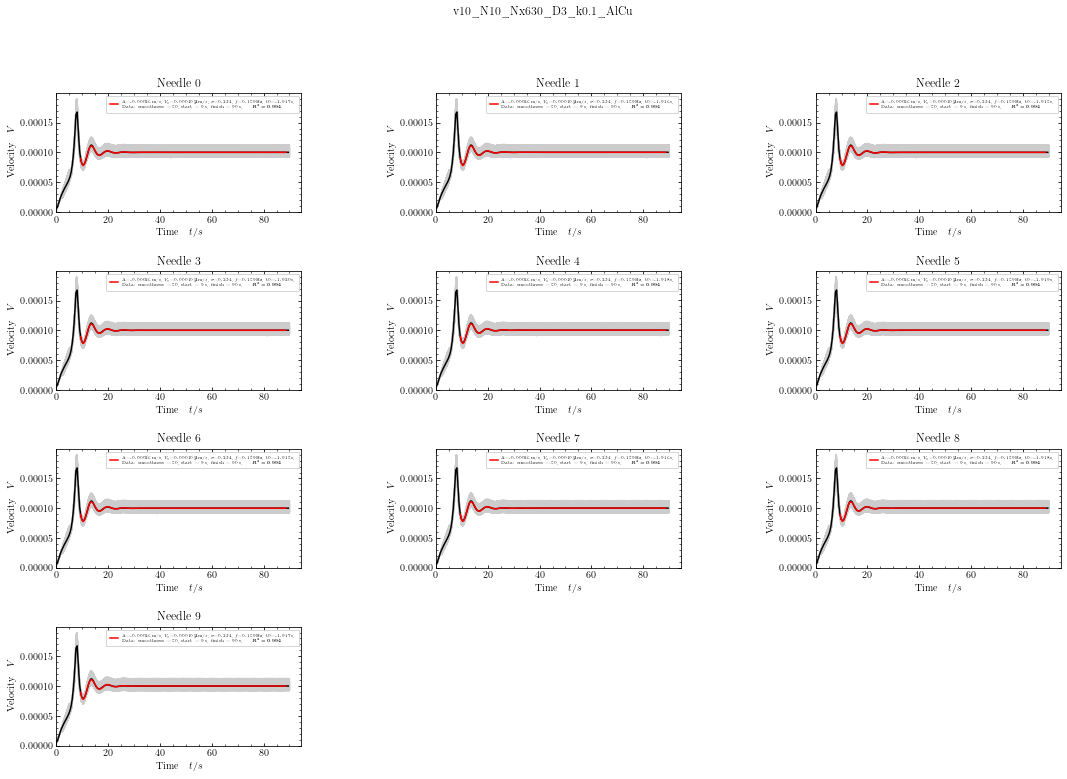

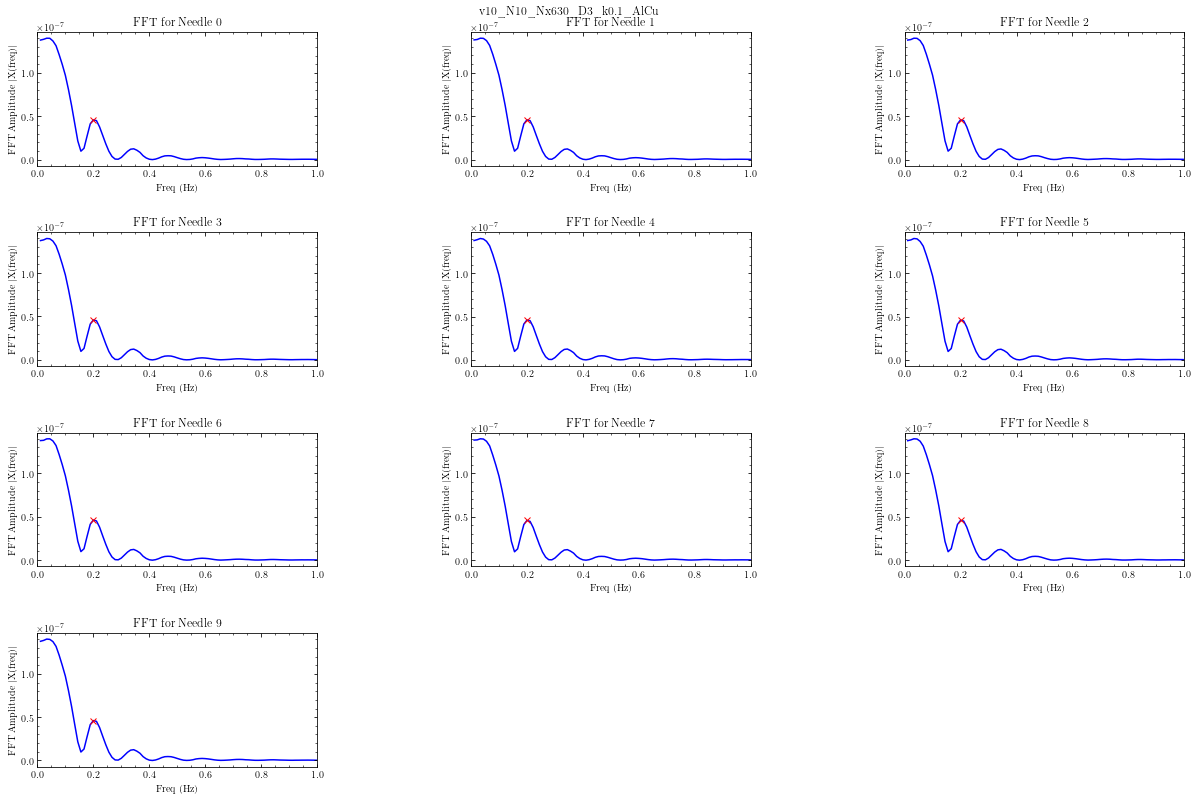

In [82]:
## FOR MANY NEEDLES
if HOME == 1:
    path = "/home/josep/Documents/IMDEA/Simulations/Partition_coefficient_0.14"
else:
    path = "/home/josepbarbera/Documents/Simulations/Partition_coefficient_0.1"
os.chdir(path)

folders = glob.glob("v10_N10_*")
desired_start = 9
folders.sort()
print(folders)
for folder in folders:
    folder_wd = path + '/' + folder
    os.chdir(folder_wd)
    needle_list = glob.glob("*needle0**.dat")
    needle_list.sort()
    
    y_tip = []
    for file in needle_list:
        last_line = last_line_from_file(folder_wd + '/' + file)
        y_tip.append(float(last_line[Y_TIP])) 
    
    i = 0
    survival_needles = list(range(len(y_tip)))
    for tip in y_tip:
        if tip < (0.15*np.max(y_tip)):
            survival_needles.remove(i)
        i = i + 1
    folder = str(folder)
    plot_name = folder[: folder.rfind('_G')]
    N = get_needles_number(plot_name)
    if len(survival_needles) < N:
        print('jumping to next folder')
        continue
    print('fitting: ', plot_name)
    dimensionless = 0
    fitting_plots = folder_wd + '/fitting_plots'
    if not os.path.exists('fitting_plots'):
        os.makedirs('fitting_plots')
    os.chdir(fitting_plots)
    data = plot_big_grid_fitted(desired_start, survival_needles, needle_list, plot_name, folder_wd, dimensionless)
    
    if FITTING == True:
        file_name = 'needles_spiky_fitting.txt'
        f = open(file_name, 'w')  # open file in append mode
        f.write('needle r_squared start end A V_0 S f t_0\n')
        for i in range(len(data)):
            f.write('%d %.3e %d %d ' %tuple([data[i][0],data[i][1],data[i][2],data[i][3]]) + 
                '%.5e %.5e %.2f %.3e %.3f\n' %tuple(data[i][4]))
        f.close()
    else:
        file_name = 'needles_decaying_fitting.txt'
        f = open(file_name, 'w')  # open file in append mode
        f.write('needle r_squared start end A V_0 sigma f t_0\n')
        for i in range(len(data)):
            f.write('%d %.3e %d %d ' %tuple([data[i][0],data[i][1],data[i][2],data[i][3]]) + 
                '%.5e %.5e %.2f %.3e %.3f\n' %tuple(data[i][4]))
        f.close()
os.chdir(path)

## That's the other fitting function used (move up this and move down the other 'fitting')
### (do not forget to change FITTING to False)

In [19]:
def fitting(time_to_start, time_to_finish, data_time_collapsed, data_dLdt, freq_max, vp):
    ##################################################################
    ### fitting desired curve to our data                         ####
    ##################################################################
    start = np.where(data_time_collapsed > time_to_start)[0][0]
    #print('start', start)
    #print(data_time_collapsed)
    finish = np.where(data_time_collapsed > (time_to_finish-1))[0][0]
    #print('finish', finish)
    xfit_data = data_time_collapsed[start:finish]
    yfit_data = data_dLdt[start:finish]
    #spiky_function(amp, v0, sp, f, t0):
    popt, pcov = curve_fit(spiky_function,  # our function
                            xfit_data,           # measured x values
                            yfit_data            # measured y values
        ###                         (amp, v0 , sp, f,   t0)  (amp,  v0 ,  sp, f,   t0)
                          ,bounds = ([0, 0, 0.0, 0.0, -100.0], [10*vp, 2*vp, 1.0, 1.0, 100.0]) 
        ###                   (amp, v0 , sp,    f,    t0)
                          ,p0=(2*vp, vp, 0.5, freq_max, 0.0)  # the initial guess for the four parameters
                         )
    residuals = yfit_data - spiky_function(xfit_data, *popt)
    #### R² value ###
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((yfit_data - np.mean(yfit_data))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared, xfit_data, yfit_data, popt, pcov